In [1]:
# import libraries and magics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras

## Problem 1

In [2]:
# Loading Training Data
X_train_full = np.load('flower_species_classification/data_train.npy').T
t_train_full = np.load('flower_species_classification/labels_train.npy')

class_names = ['Roses', 'Magnolias', 'Lilies', 'Sunflowers', 'Orchids', 
               'Marigold', 'Hibiscus', 'Firebush', 'Pentas', 'Bougainvillea']

# X_val, X_train = X_train_full[:300]/255.0, X_train_full[300:]/255.0 
# t_val, t_train = t_train_full[:300], t_train_full[300:]

X_train, X_val, t_train, t_val = train_test_split(X_train_full, t_train_full,
                                                  test_size=0.2,
                                                  stratify=t_train_full,
                                                  shuffle=True,
                                                  random_state=42)

print(X_train_full.shape, t_train_full.shape)
print(X_train.shape, t_train.shape)
print(X_val.shape, t_val.shape)

(1658, 270000) (1658,)
(1326, 270000) (1326,)
(332, 270000) (332,)


In [3]:
# Scale the training data
X_train_scaled = X_train / 255.0
X_val_scaled = X_val /255.0

In [5]:
X_train_rs = tf.constant(X_train_scaled.reshape((X_train_scaled.shape[0],300,300,3)),
                         dtype=tf.float16)
X_val_rs = tf.constant(X_val_scaled.reshape((X_val_scaled.shape[0], 300,300,3)), 
                       dtype=tf.float16)

X_train_rs.shape, X_val_rs.shape

(TensorShape([1326, 300, 300, 3]), TensorShape([332, 300, 300, 3]))

In [6]:
# Define function for evaluating performance
def Evaluate_performance(model, history, Name, X_train=X_train_rs, t_train=t_train, X_val=X_val_rs, t_val=t_val, display=True):
    
    y_train = np.argmax(model.predict(X_train),axis=1)
    y_val = np.argmax(model.predict(X_val),axis=1)
    
    # Accuracy
    train_acc = accuracy_score(y_train, t_train)
    val_acc = accuracy_score(y_val, t_val)
    
    # Print performance
    print('Performance of {}:\n'.format(Name))
    print('1. In training set: ')
    print(classification_report(t_train, y_train))
    print('Accuracy: {}'.format(train_acc))
    print('Confusion Matrix')
    print(confusion_matrix(t_train, y_train))
        
    print('\n ===================================================== \n')
    
    print('2. In validation set: ')
    print(classification_report(t_val, y_val))
    print('Accuracy: {}'.format(val_acc))
    print('Confusion Matrix')
    print(confusion_matrix(t_val, y_val))
    
    # Display learning curve
    if display==True:
        key_names = list(history.history.keys())
        colors = ['-r','--b','-og','-.k']

        plt.figure(figsize=(8,5))
        for i in [0,2]:
            plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
        plt.legend(fontsize=15,ncol=2)
        plt.title('Learning Curves with loss', size=15);
        
        plt.figure(figsize=(8,5))
        for i in [1,3]:
            plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
        plt.legend(fontsize=15,ncol=2)
        plt.title('Learning Curves with accuracy', size=15);

In [7]:
# Model 1: Only use ANN
model_prob1_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[300,300,3]),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(10, activation='softmax')
    ])

In [8]:
model_prob1_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 270000)            0         
                                                                 
 dense (Dense)               (None, 300)               81000300  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 81,031,410
Trainable params: 81,031,410
No

In [9]:
model_prob1_1.compile(optimizer=keras.optimizers.Nadam(),
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

In [11]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          patience=20)
checkpoint = keras.callbacks.ModelCheckpoint('Model/model_problem1_one.h5', 
                                             save_best_only=True)

history = model_prob1_1.fit(X_train_rs, t_train, 
                          epochs=100, 
                          batch_size=32,
                          validation_data=(X_val_rs, t_val),
                          callbacks=[earlystop, checkpoint])

Epoch 1/100
42/42 [==============================] - 2s 49ms/step - loss: 20.6611 - accuracy: 0.2722 - val_loss: 13.3653 - val_accuracy: 0.2289
Epoch 2/100
42/42 [==============================] - 2s 49ms/step - loss: 22.1139 - accuracy: 0.2896 - val_loss: 9.1887 - val_accuracy: 0.3916
Epoch 3/100
42/42 [==============================] - 1s 17ms/step - loss: 5.6325 - accuracy: 0.4744 - val_loss: 10.3024 - val_accuracy: 0.2108
Epoch 4/100
42/42 [==============================] - 1s 18ms/step - loss: 5.7164 - accuracy: 0.4698 - val_loss: 13.6342 - val_accuracy: 0.2952
Epoch 5/100
42/42 [==============================] - 1s 17ms/step - loss: 32.5836 - accuracy: 0.2602 - val_loss: 18.2549 - val_accuracy: 0.3494
Epoch 6/100
42/42 [==============================] - 2s 51ms/step - loss: 7.5491 - accuracy: 0.5030 - val_loss: 8.3327 - val_accuracy: 0.3193
Epoch 7/100
42/42 [==============================] - 2s 51ms/step - loss: 3.8687 - accuracy: 0.5686 - val_loss: 4.6841 - val_accuracy: 0.3735

Performance of ANN:

1. In training set: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       141
         1.0       1.00      1.00      1.00       144
         2.0       1.00      1.00      1.00       164
         3.0       1.00      1.00      1.00       112
         4.0       1.00      1.00      1.00       138
         5.0       1.00      1.00      1.00       125
         6.0       1.00      1.00      1.00       128
         7.0       1.00      1.00      1.00       138
         8.0       1.00      1.00      1.00       130
         9.0       1.00      1.00      1.00       106

    accuracy                           1.00      1326
   macro avg       1.00      1.00      1.00      1326
weighted avg       1.00      1.00      1.00      1326

Accuracy: 1.0
Confusion Matrix
[[141   0   0   0   0   0   0   0   0   0]
 [  0 144   0   0   0   0   0   0   0   0]
 [  0   0 164   0   0   0   0   0   0   0]
 [  0   0   0 112   0   0   0   0   0  

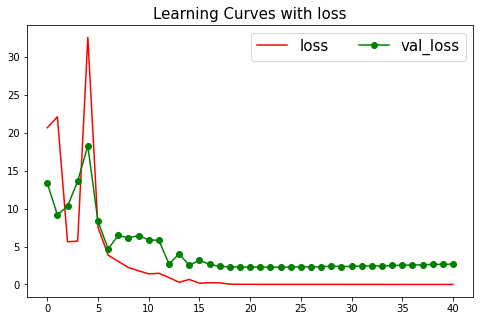

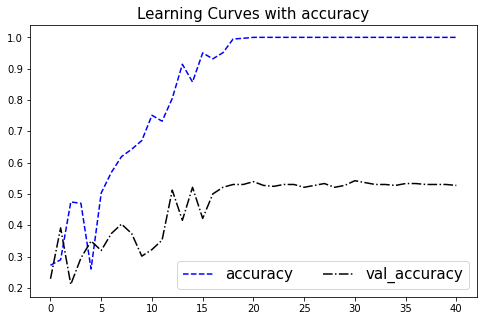

In [12]:
## Performance result
model = keras.models.load_model('Model/model_problem1_one.h5')
Evaluate_performance(model=model, history=history, Name='ANN')

In [22]:
# Model 2: With convolution layers
model_prob1_2 = keras.models.Sequential([
    keras.layers.Conv2D(64, 10, activation='selu', padding='same', input_shape=[300,300,3], kernel_initializer='lecun_normal'), 
    keras.layers.MaxPooling2D(2), 
    keras.layers.Conv2D(128, 5, activation='selu', padding='same', kernel_initializer='lecun_normal'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Conv2D(256, 3, activation='selu', padding='same', kernel_initializer='lecun_normal'),
    keras.layers.MaxPooling2D(2),
    keras.layers.Flatten(),
    keras.layers.Dense(300, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(100, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dropout(0.2), 
    keras.layers.Dense(10, activation='softmax')
    ])

In [23]:
model_prob1_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 300, 300, 64)      19264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 150, 150, 64)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 150, 150, 128)     204928    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 75, 75, 128)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 75, 75, 256)       295168    
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 37, 37, 256)     

In [24]:
model_prob1_2.compile(optimizer=keras.optimizers.Nadam(),
                    loss=keras.losses.SparseCategoricalCrossentropy(),
                    metrics=['accuracy'])

In [25]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          patience=10)
checkpoint = keras.callbacks.ModelCheckpoint('Model/model_problem1_two.h5', 
                                             save_best_only=True)

history = model_prob1_2.fit(X_train_rs, t_train, 
                          epochs=100, 
                          batch_size=32,
                          validation_data=(X_val_rs, t_val),
                          callbacks=[earlystop, checkpoint])

Epoch 1/100
42/42 [==============================] - 5s 110ms/step - loss: 122.3389 - accuracy: 0.2474 - val_loss: 9.7673 - val_accuracy: 0.3012
Epoch 2/100
42/42 [==============================] - 5s 109ms/step - loss: 4.6592 - accuracy: 0.4789 - val_loss: 2.4258 - val_accuracy: 0.5422
Epoch 3/100
42/42 [==============================] - 3s 60ms/step - loss: 1.7899 - accuracy: 0.6252 - val_loss: 4.2336 - val_accuracy: 0.3524
Epoch 4/100
42/42 [==============================] - 5s 109ms/step - loss: 1.4020 - accuracy: 0.6983 - val_loss: 2.2027 - val_accuracy: 0.5211
Epoch 5/100
42/42 [==============================] - 4s 108ms/step - loss: 0.5769 - accuracy: 0.8258 - val_loss: 1.9680 - val_accuracy: 0.5723
Epoch 6/100
42/42 [==============================] - 4s 108ms/step - loss: 1.4059 - accuracy: 0.8100 - val_loss: 1.9198 - val_accuracy: 0.5783
Epoch 7/100
42/42 [==============================] - 2s 59ms/step - loss: 0.9238 - accuracy: 0.8258 - val_loss: 3.8463 - val_accuracy: 0.5060

Performance of CNN:

1. In training set: 
              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97       141
         1.0       0.99      1.00      1.00       144
         2.0       1.00      0.88      0.94       164
         3.0       0.99      0.99      0.99       112
         4.0       0.95      0.96      0.96       138
         5.0       0.98      1.00      0.99       125
         6.0       1.00      0.95      0.97       128
         7.0       1.00      0.97      0.99       138
         8.0       0.95      1.00      0.97       130
         9.0       0.87      1.00      0.93       106

    accuracy                           0.97      1326
   macro avg       0.97      0.97      0.97      1326
weighted avg       0.97      0.97      0.97      1326

Accuracy: 0.9698340874811463
Confusion Matrix
[[138   0   0   0   0   1   0   0   1   1]
 [  0 144   0   0   0   0   0   0   0   0]
 [  3   1 144   0   7   0   0   0   0   9]
 [  0   0   0 111   0   

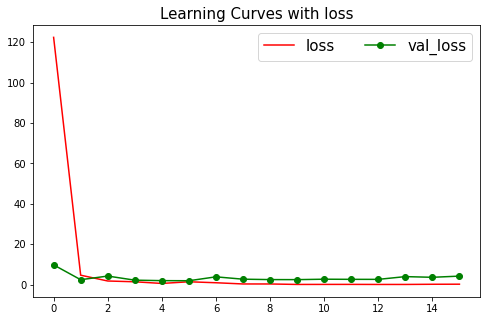

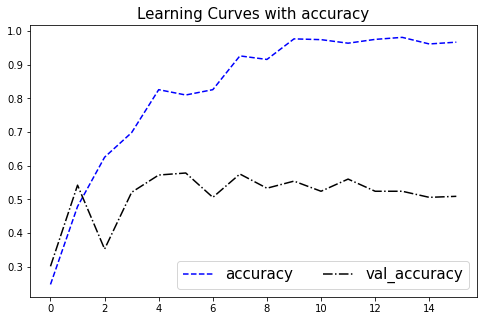

In [26]:
## Performance result
model = keras.models.load_model('Model/model_problem1_two.h5')
Evaluate_performance(model=model, history=history, Name='CNN')

In [26]:
# Model 3: With transfer learning
base_model = keras.applications.Xception(
    weights='imagenet', 
    input_shape=(150, 150, 3),
    include_top=False)

base_model.trainable = False

IMG_SIZE = 150

inputs = keras.Input(shape=(300, 300, 3))
inputs_resized = keras.layers.Resizing(IMG_SIZE, IMG_SIZE)(inputs) 
x = base_model(inputs_resized, training=False)
x_pooling = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(10, activation='softmax')(x_pooling)
model_prob1_3 = keras.Model(inputs, outputs)

In [27]:
model_prob1_3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 resizing_2 (Resizing)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_9 (Dense)             (None, 10)                20490     
                                                                 
Total params: 20,881,970
Trainable params: 20,490
Non-trainable params: 20,861,480
__________________________________________

In [28]:
model_prob1_3.compile(optimizer=keras.optimizers.Nadam(learning_rate=0.001),
                      loss=keras.losses.SparseCategoricalCrossentropy(),
                      metrics=['accuracy'])

In [29]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          patience=10)
checkpoint = keras.callbacks.ModelCheckpoint('Model/model_problem1_three.h5', 
                                             save_best_only=True)

history = model_prob1_3.fit(X_train_rs, t_train, 
                            epochs=100, 
                            batch_size=32,
                            validation_data=(X_val_rs, t_val),
                            callbacks=[earlystop, checkpoint])

Epoch 1/100
42/42 [==============================] - 3s 38ms/step - loss: 1.5644 - accuracy: 0.5332 - val_loss: 1.0672 - val_accuracy: 0.6988
Epoch 2/100
42/42 [==============================] - 1s 26ms/step - loss: 0.8523 - accuracy: 0.7919 - val_loss: 0.8153 - val_accuracy: 0.7229
Epoch 3/100
42/42 [==============================] - 1s 27ms/step - loss: 0.6505 - accuracy: 0.8318 - val_loss: 0.7074 - val_accuracy: 0.7620
Epoch 4/100
42/42 [==============================] - 1s 30ms/step - loss: 0.5395 - accuracy: 0.8718 - val_loss: 0.6285 - val_accuracy: 0.8133
Epoch 5/100
42/42 [==============================] - 1s 32ms/step - loss: 0.4689 - accuracy: 0.8922 - val_loss: 0.5854 - val_accuracy: 0.8012
Epoch 6/100
42/42 [==============================] - 1s 27ms/step - loss: 0.4123 - accuracy: 0.9080 - val_loss: 0.5474 - val_accuracy: 0.8193
Epoch 7/100
42/42 [==============================] - 1s 28ms/step - loss: 0.3669 - accuracy: 0.9201 - val_loss: 0.5238 - val_accuracy: 0.8253
Epoch 

Performance of Transfer learning:

1. In training set: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       141
         1.0       1.00      1.00      1.00       144
         2.0       1.00      1.00      1.00       164
         3.0       1.00      1.00      1.00       112
         4.0       1.00      1.00      1.00       138
         5.0       1.00      1.00      1.00       125
         6.0       1.00      1.00      1.00       128
         7.0       1.00      1.00      1.00       138
         8.0       1.00      1.00      1.00       130
         9.0       1.00      1.00      1.00       106

    accuracy                           1.00      1326
   macro avg       1.00      1.00      1.00      1326
weighted avg       1.00      1.00      1.00      1326

Accuracy: 1.0
Confusion Matrix
[[141   0   0   0   0   0   0   0   0   0]
 [  0 144   0   0   0   0   0   0   0   0]
 [  0   0 164   0   0   0   0   0   0   0]
 [  0   0   0 112   0   0

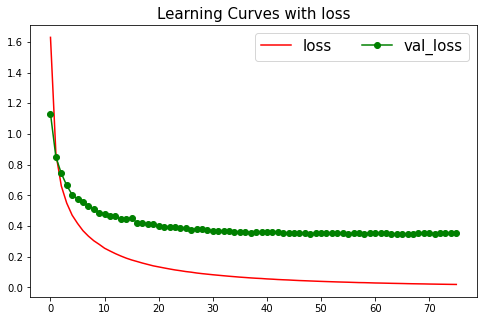

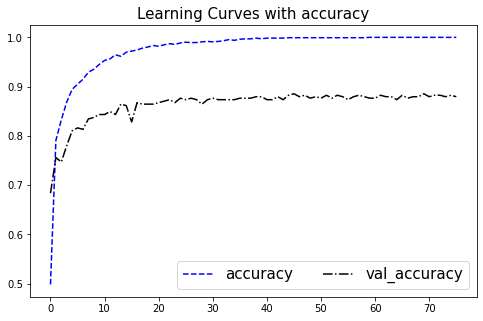

In [18]:
## Performance result
model = keras.models.load_model('Model/model_problem1_three.h5')
Evaluate_performance(model=model, history=history, Name='Transfer learning')

## Problem 3

In [2]:
bbox = pd.read_csv('car_detection_dataset/train_bounding_boxes.csv')

N = len(bbox)

# Create a numpy array with all images
for i in range(N): 
    filename='car_detection_dataset/training_images/'+bbox['image'][i]
    image = np.array(Image.open(filename))
    image_col = image.ravel()[:,np.newaxis]
    
    if i==0:
        X_train_full = image_col
    else:
        X_train_full = np.hstack((X_train_full, image_col))

# Training feature matrices
X_train_full = X_train_full.T

# Training labels
t_train_full = bbox.drop('image', axis=1).round().to_numpy().astype(int)

X_train_full.shape, t_train_full.shape

((559, 770640), (559, 4))

In [3]:
# size of each RGB image
(Nx,Ny,Nz) = image.shape

Nx, Ny, Nz

(380, 676, 3)

In [4]:
# Scale and split the training data and the target
X_train_scaled = X_train_full / 255.0
t_train_scaled = np.vstack((t_train_full[:,0]/Ny, t_train_full[:,1]/Nx, t_train_full[:,2]/Ny, t_train_full[:,3]/Nx)).T

X_val, X_train = X_train_scaled[:50], X_train_scaled[50:]
t_val, t_train = t_train_scaled[:50], t_train_scaled[50:]

X_train.shape, t_train.shape, X_val.shape, t_val.shape

((509, 770640), (509, 4), (50, 770640), (50, 4))

In [15]:
# Reshape the data
X_train_rs = tf.constant(X_train.reshape((X_train.shape[0],Nx,Ny,3)),
                         dtype=tf.float16)
X_val_rs = tf.constant(X_val.reshape((X_val.shape[0], Nx,Ny,3)), 
                       dtype=tf.float16)

X_train_rs.shape, X_val_rs.shape

(TensorShape([509, 380, 676, 3]), TensorShape([50, 380, 676, 3]))

In [20]:
# Build the model
base_model = keras.applications.VGG16(
    weights='imagenet', 
    input_tensor=keras.layers.Input(shape=(224, 224, 3)),
    include_top=False)

base_model.trainable = False

inputs = keras.Input(shape=(Nx, Ny, Nz))
inputs_resized = keras.layers.Resizing(224, 224)(inputs) 
x = base_model(inputs_resized, training=False)
x_flatten = keras.layers.Flatten()(x)
layer1 = keras.layers.Dense(128, activation="selu", kernel_initializer='lecun_normal')(x_flatten)
layer2 = keras.layers.Dense(64, activation="selu", kernel_initializer='lecun_normal')(layer1)
layer3 = keras.layers.Dense(32, activation="selu", kernel_initializer='lecun_normal')(layer2)
outputs = keras.layers.Dense(4, activation="sigmoid")(layer3)
model_prob2 = keras.Model(inputs, outputs)

In [21]:
model_prob2.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 380, 676, 3)]     0         
                                                                 
 resizing_4 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 25088)             0         
                                                                 
 dense_16 (Dense)            (None, 128)               3211392   
                                                                 
 dense_17 (Dense)            (None, 64)                8256      
                                                                 
 dense_18 (Dense)            (None, 32)                2080

In [22]:
model_prob2.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
                      loss=keras.losses.MeanSquaredError())

In [23]:
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          patience=10)
checkpoint = keras.callbacks.ModelCheckpoint('Model/model_problem2.h5', 
                                             save_best_only=True)

history = model_prob2.fit(X_train_rs, t_train, 
                          epochs=50, 
                          batch_size=10,
                          validation_data=(X_val_rs, t_val),
                          callbacks=[earlystop, checkpoint])

Epoch 1/50
51/51 [==============================] - 1s 17ms/step - loss: 0.2100 - val_loss: 0.2165
Epoch 2/50
51/51 [==============================] - 1s 15ms/step - loss: 0.2022 - val_loss: 0.1936
Epoch 3/50
51/51 [==============================] - 1s 14ms/step - loss: 0.1733 - val_loss: 0.1348
Epoch 4/50
51/51 [==============================] - 1s 14ms/step - loss: 0.1028 - val_loss: 0.0988
Epoch 5/50
51/51 [==============================] - 1s 15ms/step - loss: 0.0860 - val_loss: 0.0987
Epoch 6/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0808 - val_loss: 0.0896
Epoch 7/50
51/51 [==============================] - 1s 11ms/step - loss: 0.0803 - val_loss: 0.0978
Epoch 8/50
51/51 [==============================] - 1s 11ms/step - loss: 0.0822 - val_loss: 0.0942
Epoch 9/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0782 - val_loss: 0.0879
Epoch 10/50
51/51 [==============================] - 1s 14ms/step - loss: 0.0756 - val_loss: 0.0865
Epoch 11/

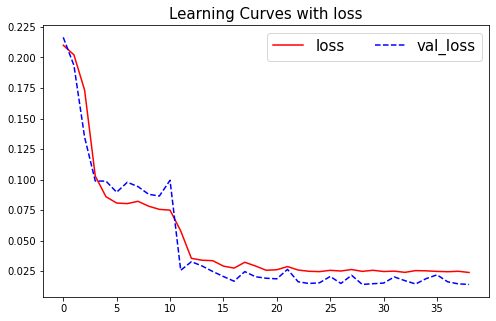

In [24]:
key_names = list(history.history.keys())
colors = ['-r','--b']

plt.figure(figsize=(8,5))
for i in [0,1]:
    plt.plot(history.history[key_names[i]], colors[i], label=key_names[i])
plt.legend(fontsize=15,ncol=2)
plt.title('Learning Curves with loss', size=15);